In this notebook, we build a simple convoluation neural network using tensorflow to classify Fashion-MNIST  dataset (https://www.kaggle.com/zalando-research/fashionmnist),  which is a dataset of Zalando's article images. The training set consists of 60k examples and test set consists of 10k examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes as mentioned below.
* 0 T-shirt/top
* 1 Trouser
* 2 Pullover
* 3 Dress
* 4 Coat
* 5 Sandal
* 6 Shirt
* 7 Sneaker
* 8 Bag
* 9 Ankle boot 


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt

%matplotlib inline

/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
input_shape = [None, 28, 28, 1]
number_of_classes = 10

In [3]:
#load training and testing data
train_data = pd.read_csv('fashion-mnist_train.csv')
test_data = pd.read_csv('fashion-mnist_test.csv')

print("Training data shape: {}".format(train_data.shape))
print("Test data shape: {}".format(test_data.shape))

Training data shape: (60000, 785)
Test data shape: (10000, 785)


In [4]:
#for training data separate features and labels
train_data_x = train_data.iloc[:, 1:785]
train_data_y = train_data.iloc[:, 0:1]

#for test data separate features and labels
test_data_x = test_data.iloc[:, 1:785]
test_data_y = test_data.iloc[:, 0:1]

In [5]:
#scale features data
train_data_x = train_data_x/255
test_data_x = test_data_x/255

#Lets convert our training and testing data from pandas dataframes into numpy 
#arrays needed to train our model

train_x = train_data_x.as_matrix()
train_y = train_data_y.as_matrix()

test_x = test_data_x.as_matrix()
test_y = test_data_y.as_matrix()

train_x = train_x.reshape(train_x.shape[0], input_shape[1], 
                          input_shape[2], input_shape[3])
test_x = test_x.reshape(test_x.shape[0], input_shape[1], 
                          input_shape[2], input_shape[3])
#Conver output label to one hot vector
train_y = to_categorical(train_y, 10)
test_y = to_categorical(test_y, 10)


print("Shape of training features: {}".format(train_x.shape))
print("Shape of training lables: {}".format(train_y.shape))
print("Shape of testing features: {}".format(test_x.shape))
print("Shape of testing lables: {}".format(test_y.shape))

Shape of training features: (60000, 28, 28, 1)
Shape of training lables: (60000, 10)
Shape of testing features: (10000, 28, 28, 1)
Shape of testing lables: (10000, 10)


In [6]:
#Split the training set into training and cross validation set. We will use the cross validation
#set to check how well our model is doing on unseen training example.

train_x, cv_x, train_y, cv_y = train_test_split(train_x, train_y, 
                                                test_size = 5000, random_state = 42)

print("Number of examples in training set: {}".format(train_x.shape[0]))
print("Number of examples in cross validation set: {}".format(cv_x.shape[0]))

Number of examples in training set: 55000
Number of examples in cross validation set: 5000


In [7]:
#Function below builds model graph 
def cnn_model_fn(input_shape, number_of_classes, learning_rate):
    
    input_layer = tf.placeholder(tf.float32, shape=input_shape)
    labels = tf.placeholder(tf.float32, shape=[None, number_of_classes])
    
    #Train mode is used with dropout layers. We want effectively disable the dropout layers while
    #evaluation and predict and use it only while training
    train_mode = tf.placeholder(tf.bool)
    
    #Architecture: image ->conv2d->maxpooling->conv2d->maxpooling->flatten->dense->dropout->logits->softmax
    
    #convolution layer 1
    conv1 = tf.layers.conv2d(
        inputs=input_layer, 
        filters=32, 
        kernel_size=[5, 5], 
        padding="same", 
        activation=tf.nn.relu)
    
    #pooling layer 1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    
    #convolution layer 2
    conv2 = tf.layers.conv2d(
        inputs=pool1, 
        filters=64, 
        kernel_size=[5, 5], 
        padding="same", 
        activation=tf.nn.relu)
    
    #pooling layer 1
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    #flatten the output volume of pool2 into a vector
    pool2_flat = tf.reshape(pool2, shape=[-1, 7*7*64])
    
    #dense layer
    dense = tf.layers.dense(
        inputs=pool2_flat, 
        units=1024,
        activation=tf.nn.relu)
    
    #dropout regularization
    dropout = tf.layers.dropout(
        inputs=dense, 
        rate=0.3, 
        training= train_mode)
    
    #logits layer
    logits = tf.layers.dense(inputs=dropout, units=10)
    
    predictions = {
        "classes" : tf.argmax(input=logits, axis=1),
        "probabilities" : tf.nn.softmax(logits=logits)
    }
    
    #loss
    loss = tf.losses.softmax_cross_entropy(labels, logits)
    
    #training operartion
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
    #accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1)), tf.float32))
    
    return { "logits": logits,
             "predictions": predictions,
             "loss": loss,
             "train_op": train_op,
             "accuracy": accuracy,
             "x": input_layer,
             "y": labels,
             "train_mode": train_mode }

In [8]:
#Hyper parameters
learning_rate = 0.01
batch_size = 128
epoch = 3


tf.reset_default_graph()
cnn_model = cnn_model_fn(input_shape, number_of_classes, learning_rate)
x = cnn_model["x"]
y= cnn_model["y"]
train_mode = cnn_model["train_mode"]

In [9]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    #Divide input training set into mini batches of size batch_size.
    #If the total number of training examles is not exactly divisible by batch_size, 
    #the last batch will have less number of examples than batch_size.
    
    total_size = train_x.shape[0]
    number_of_batches = int(total_size/batch_size)
    
    print("Training:Start")
    for e in range(epoch):
        epoch_cost = 0
        epoch_accuracy = 0
        print("Epoch {}:".format(e+1))
        for i in range(number_of_batches):
            print("#", end='')
            mini_x = train_x[i*batch_size:(i+1)*batch_size, :, :, :]
            mini_y = train_y[i*batch_size:(i+1)*batch_size, :]
            _, cost = sess.run([cnn_model["train_op"], cnn_model["loss"]], 
                feed_dict={x:mini_x, 
                           y:mini_y,
                           train_mode:True})
            train_accuracy = sess.run(cnn_model["accuracy"], 
                feed_dict={x:mini_x, 
                           y:mini_y,
                           train_mode:False})
            epoch_cost += cost
            epoch_accuracy += train_accuracy
        
        #If the total number of training examles is not exactly divisible by batch_size, 
        #we have one more batch of size (total_size - number_of_batches*batch_size)
        if total_size % batch_size != 0:
            print("#", end='')
            mini_x = train_x[number_of_batches*batch_size:total_size, :, :, :]
            mini_y = train_y[number_of_batches*batch_size:total_size, :]
            _, cost = sess.run([cnn_model["train_op"], cnn_model["loss"]], 
                feed_dict={x:mini_x, 
                           y:mini_y,
                           train_mode:True})
            train_accuracy = sess.run(cnn_model["accuracy"], 
                feed_dict={x:mini_x, 
                           y:mini_y,
                           train_mode: False})
            epoch_cost += cost
            epoch_accuracy += train_accuracy
        
        epoch_cost /= number_of_batches
        
        if total_size % batch_size != 0:
            epoch_accuracy /= (number_of_batches+1)
        else:
            epoch_accuracy /= number_of_batches
        print()    
        print("loss: {:02.2f} accuracy: {:02.2f} ".format(np.squeeze(epoch_cost), epoch_accuracy))
        #Cross validation loss and accuracy
        cv_loss, cv_accuracy = sess.run([cnn_model["loss"], cnn_model["accuracy"]], 
                                    {x:cv_x, 
                                     y:cv_y,
                                     train_mode: False})
        print("val_loss: {:02.2f} val_accuracy: {:02.2f}".format(np.squeeze(cv_loss), cv_accuracy))
    
    print("Training:End")
    
    
    #prediction for test set
    test_accuracy, prediction = sess.run([cnn_model["accuracy"], 
                                          cnn_model["predictions"]["classes"]], 
                                         {x:test_x, y:test_y, train_mode:False})
    print("Test accuracy {:02.2f}".format(test_accuracy))

Training:Start
Epoch 1:
##############################################################################################################################################################################################################################################################################################################################################################################################################################################
loss: 0.49 accuracy: 0.85 
val_loss: 0.33 val_accuracy: 0.87
Epoch 2:
##############################################################################################################################################################################################################################################################################################################################################################################################################################################
loss: 0.33 accuracy: 0.90 
val_loss: 0.30 va

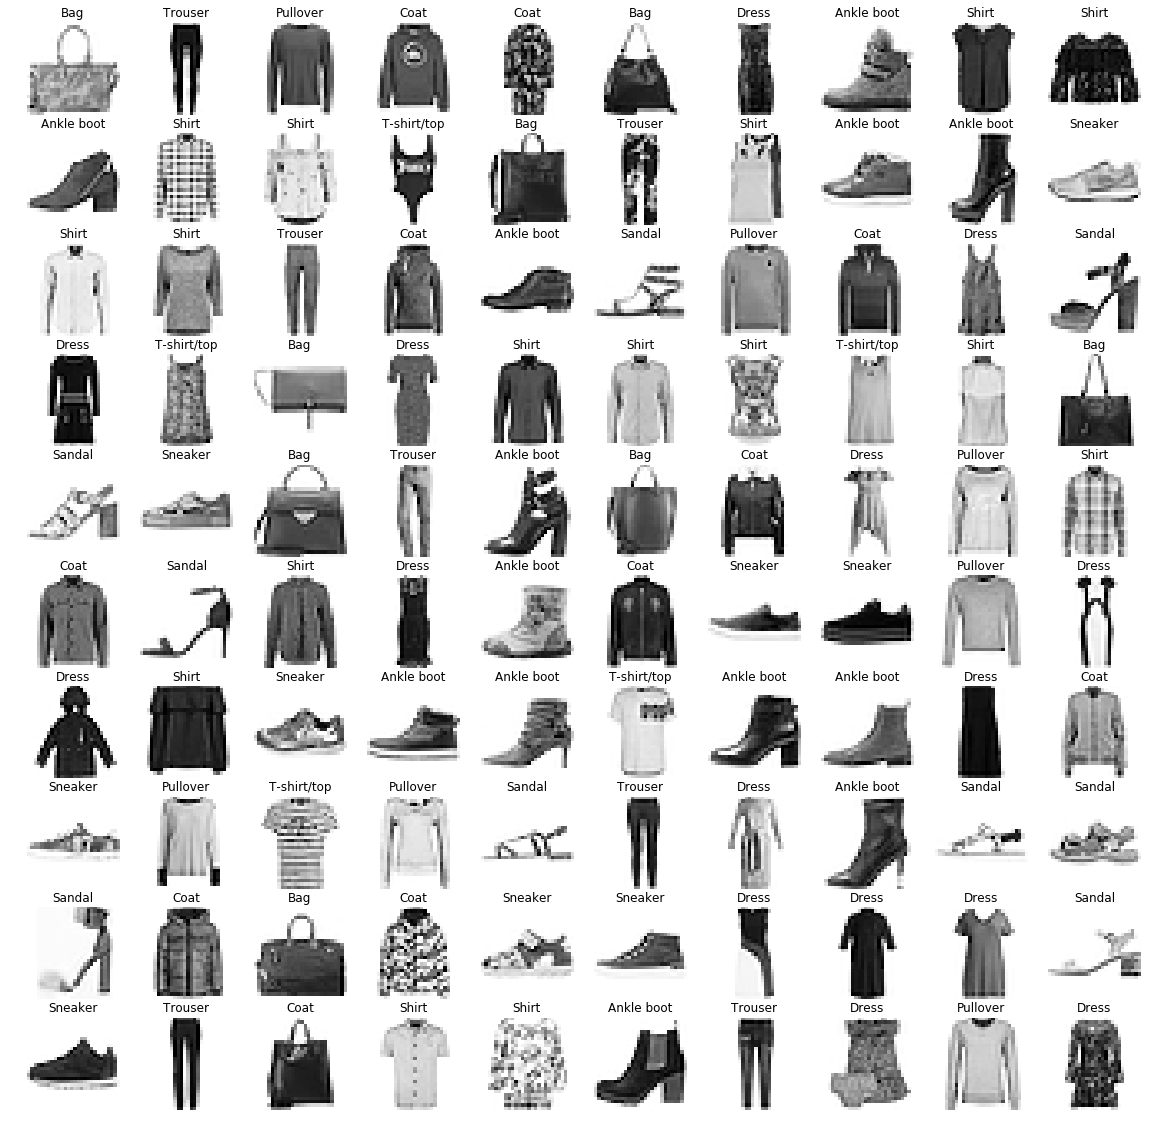

In [10]:
labels={'0':'T-shirt/top', '1': 'Trouser', '2' :'Pullover', '3':'Dress', '4': 'Coat', 
        '5': 'Sandal', '6': 'Shirt', '7': 'Sneaker', '8': 'Bag', '9': 'Ankle boot'} 

#Let us choose random 100 images from test set and see 
#actual image and predicted label by our model for the same
predicted_labels = prediction
permutations = np.random.permutation(10000)

fig, axs = plt.subplots(10, 10, figsize = (20, 20))
for r in range(10):
  for c in range(10):
    axs[r, c].imshow(np.reshape(test_x[permutations[10*r+c], :, :, :]*255, [input_shape[1], input_shape[2]]), cmap='Greys')
    axs[r, c].axis('off')
    axs[r, c].set_title(labels[str(predicted_labels[permutations[10*r+c]])])